In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Import Libraries

In [39]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.svm import SVC
from unidecode import unidecode
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer as PS
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score
from nltk.tokenize import WordPunctTokenizer as WPT
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

In [40]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [41]:
train_val = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [42]:
stopwords_list = stopwords.words('english')


# Clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    return text

## Exploratory Data Analysis

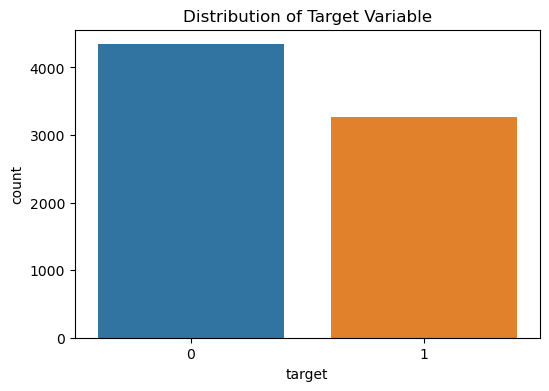

In [43]:
# Plot the distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_val)
plt.title('Distribution of Target Variable')
plt.show()

Based on the distribution shown in the chart, it appears that there were around 3,000 recorded disasters (represented by the number 1) and approximately 4,200 disasters that were not recorded (represented by the number 0).

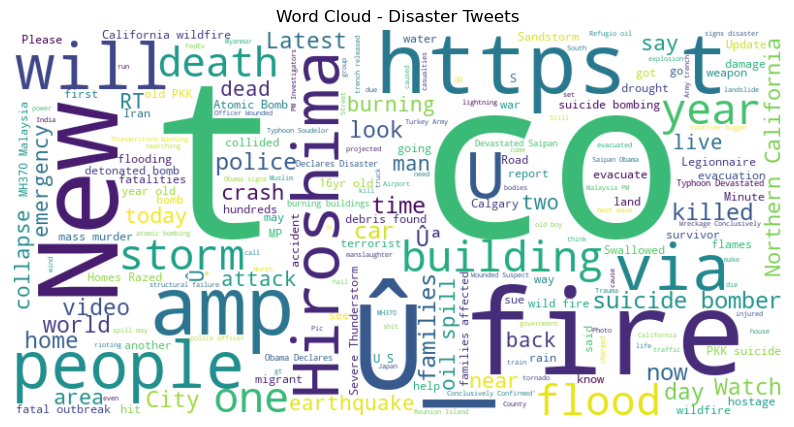

In [44]:
# Plot the word cloud for disaster tweets
disaster_tweets = train_val[train_val['target'] == 1]['text']
disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_tweets))
plt.figure(figsize=(10, 6))
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets')
plt.axis('off')
plt.show()

According to the wordcloud, some of the most frequently used words include "death," "fire," "building," "new," "killed," "will," "https," "people," and so on.

In [45]:
!pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [46]:
enc_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

## Data Encoding

In [47]:
X_train_val = df.text.apply(unidecode).to_numpy()
X_test = test.text.apply(unidecode).to_numpy()

y_train_val = train_val.target.to_numpy()

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

In [49]:
X_train = enc_model.encode(X_train)
X_val = enc_model.encode(X_val)
X_test = enc_model.encode(X_test)

Batches:   0%|          | 0/215 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

## Model Traing and Evaluation

#### Fitting the data with RandomForestClassifier

In [50]:
model = RandomForestClassifier(n_estimators=140)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=140)

In [51]:
val_ans = model.predict(X_val)
val_acc = accuracy_score(y_val, val_ans) * 100

print(f"Validation accuracy is: {val_acc:.2f}%")

Validation accuracy is: 81.10%


#### Fitting the data with LGBMClassifer

In [52]:
model = lgb.LGBMClassifier(learning_rate=0.1,random_state=50)
model.fit(X_train, y_train,eval_set=(X_val,y_val),
          eval_metric='accuracy')

[1]	valid_0's binary_logloss: 0.660685
[2]	valid_0's binary_logloss: 0.640122
[3]	valid_0's binary_logloss: 0.622874
[4]	valid_0's binary_logloss: 0.604831
[5]	valid_0's binary_logloss: 0.590446
[6]	valid_0's binary_logloss: 0.577124
[7]	valid_0's binary_logloss: 0.565768
[8]	valid_0's binary_logloss: 0.554887
[9]	valid_0's binary_logloss: 0.545912
[10]	valid_0's binary_logloss: 0.536087
[11]	valid_0's binary_logloss: 0.529074
[12]	valid_0's binary_logloss: 0.521864
[13]	valid_0's binary_logloss: 0.515242
[14]	valid_0's binary_logloss: 0.509179
[15]	valid_0's binary_logloss: 0.502647
[16]	valid_0's binary_logloss: 0.495417
[17]	valid_0's binary_logloss: 0.491013
[18]	valid_0's binary_logloss: 0.485985
[19]	valid_0's binary_logloss: 0.483485
[20]	valid_0's binary_logloss: 0.480646
[21]	valid_0's binary_logloss: 0.476587
[22]	valid_0's binary_logloss: 0.47254
[23]	valid_0's binary_logloss: 0.46947
[24]	valid_0's binary_logloss: 0.465761
[25]	valid_0's binary_logloss: 0.461228
[26]	valid_

LGBMClassifier(random_state=50)

In [53]:
val_ans = model.predict(X_val)
val_acc = accuracy_score(y_val, val_ans) * 100

print(f"Validation accuracy is: {val_acc:.2f}%")

Validation accuracy is: 79.92%


#### Fitting the data with SVC

In [54]:
model = SVC(C=0.357)
model.fit(X_train, y_train)

SVC(C=0.357)

In [55]:
val_ans = model.predict(X_val)
val_acc = accuracy_score(y_val, val_ans) * 100

print(f"Validation accuracy is: {val_acc:.2f}%")

Validation accuracy is: 82.68%


The accuracy of the SVC model is 82.68%

## Submission

In [56]:
test_ans = model.predict(X_test)
submission_df = pd.DataFrame({"id": test.id, "target": test_ans})

In [57]:
submission_df.to_csv("submission.csv", index=False)